# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 102 (delta 57), reused 33 (delta 33), pack-reused 20 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (57/57), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2.70G/2.70G [00:21<00:00, 127MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

  0%|          | 0/250 [00:00<?, ?it/s]

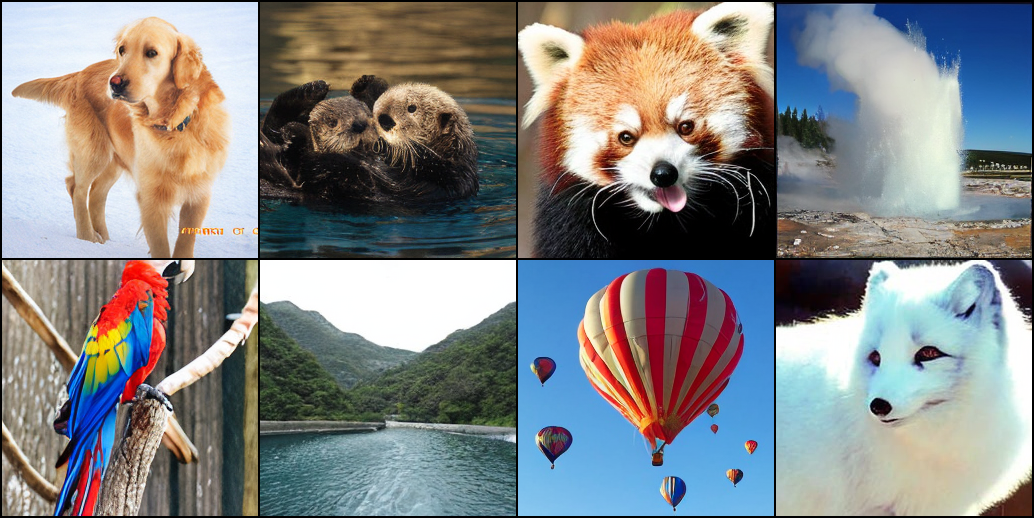

In [3]:
# Set user inputs:
seed = 2 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)